<a href="https://colab.research.google.com/github/Beatriz-Yun/AIFFEL_LMS/blob/main/Exploration/%5BE-06%5DKaggle%EC%A7%91%EA%B0%92%EC%98%88%EC%B8%A1%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C_%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [캐글 코리아와 함께하는 2nd ML 대회 - House Price Prediction](https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/overview)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


모델의 성능을 최대화하기 위해서는 이전에 진행한 하이퍼파라미터 튜닝 뿐아니라<br>
**EDA과정을 통한 feature engineering**으로 데이터를 정제하는 것도 매우 중요하다.

<br>

튜닝은 다양한 최적화 방법론 중 하나라는 것을 알아둬야 한다.

# 목차 
### 1. 데이터 탐색
    - 문제 정의
    - 변수 설명
    - 시각화 
    - 이상치 및 결측치 확인
    - 유니크 갯수
### 2. 데이터 전처리
    - 이상치 및 결측치 처리
    - 정규화
### 3. 변수 생성
### 4. 모델링 
    - 회귀
    - GBM ( LGB/XGB )
    - 앙생블 
### 5. 잔차분석 

<br><br>

---



# 1.데이터 탐색

## 1.1 문제 정의 
이번 데이터의 목적은 집의 정보를 가지고 가격을 예측하는 회귀문제 입니다. 

평가로는 RMSE를 사용합니다. 

In [8]:
import pandas as pd                     # Analysis 
import matplotlib.pyplot as plt         # Visulization
import seaborn as sns                   # Visulization
import numpy as np                      # Analysis 
from scipy.stats import norm            # Analysis 
from sklearn.preprocessing import StandardScaler # Analysis 
from scipy import stats                 # Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc


import os
from os.path import join
import missingno as msno
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

In [12]:
base_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data'
train_data_path = join(base_path, 'train.csv')
test_data_path = join(base_path, 'test.csv')

data = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

print('train data dim : {}'.format(data.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


## 1.2 변수 정의

**Data fields**
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 집의 가격(Target variable)
4. bedrooms : 침실의 수
5. bathrooms : 화장실의 수
6. sqft_living : 주거 공간의 평방 피트(면적)
7. sqft_lot : 부지의 평방 피트(면적)
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트(면적)
14. sqft_basement : 지하실의 평방 피트(면적)
15. yr_built : 지어진 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

👉 우리가 예측해야 되는 값은 'price'이다.

In [13]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


- date의 경우 yyyy-mm-dd + T000000의 형태로 저희가 필요한 부분은 앞의 8자리 입니다. 
- bathrooms의 경우 소숫점의 값이 보이는데, 이는 미국의 기준에 따른 것입니다. 자세한 내용은 아래 부분에 나옵니다. 
- yr_renovated의 경우 0의 값이 보이는데, 0년도에 재건축이 되었다는 의미가 아니라 재건축을 하지 않았다는 의미입니다. 
- sqft_living 과 sqft_living15처럼 비슷한 값이 보입니다. 둘은 15년도를 기준으로 크기 계산의 기준에 따라 다른 값을 보입니다. 둘의 차이가 꽤 큰 부분도 있어서 이를 잘 활용해야 할 것 같습니다. 

head를 통해서는 이 정도로 가볍게 변수를 이해해보고 하나하나 변수를 살펴보면서 전처리해야 할 부분과 피쳐 엔지니어링을 할 아이디어를 고민해보겠습니다. 

## 1.3 시각화

### 1) 목적 변수(price) 시각화

In [14]:
# 통계 수치
data['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

목적변수의 경우 min과 max의 차이가 크고, std가 굉장히 큰 편입니다.<br>
아래의 히스토그램을 보면 더 명확하겠지만 **왼쪽으로 분포가 굉장히 치우친 것**을 알 수 있습니다.

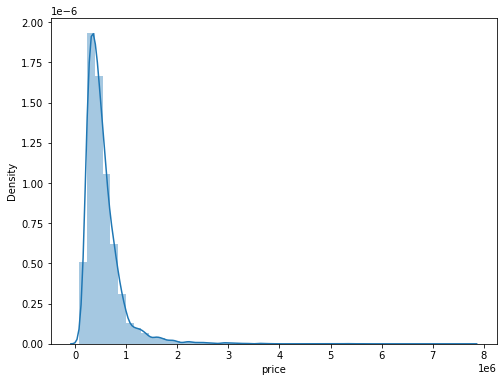

In [15]:
#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(data['price'])

- 왜도 : 오른쪽 꼬리가 길수록 값이 더 큽니다. 
- 첨도 (kurtosis / kurtosis) : 첨도 값 (K)이 3에 가까울 경우, scatter은 정규 분포에 가깝습니다. (K <3), 분포가 정규 분포보다 더 평탄하게 평탄하다고 판단 할 수 있으며, 첨도가 3보다 큰 양수인 경우 (K> 3), 분포가보다 뾰족한 분포로 간주 할 수 있습니다. 

In [16]:
#왜도와 첨도
print("Skewness(왜도): %f" % data['price'].skew())
print("Kurtosis(첨도): %f" % data['price'].kurt())

Skewness(왜도): 4.290252
Kurtosis(첨도): 40.154919


target 변수인 'price'의 경우 첨도, 왜도도 굉장히 정규분포를 따르지않고, 분산 또한 매우 큰 것을 확인할 수 있었습니다. <br>
저는 회귀모델을 사용할 것이기 때문에 Normalize를 통해 price의 분포가 정규분포를 가지도록 만들어 주겠습니다.

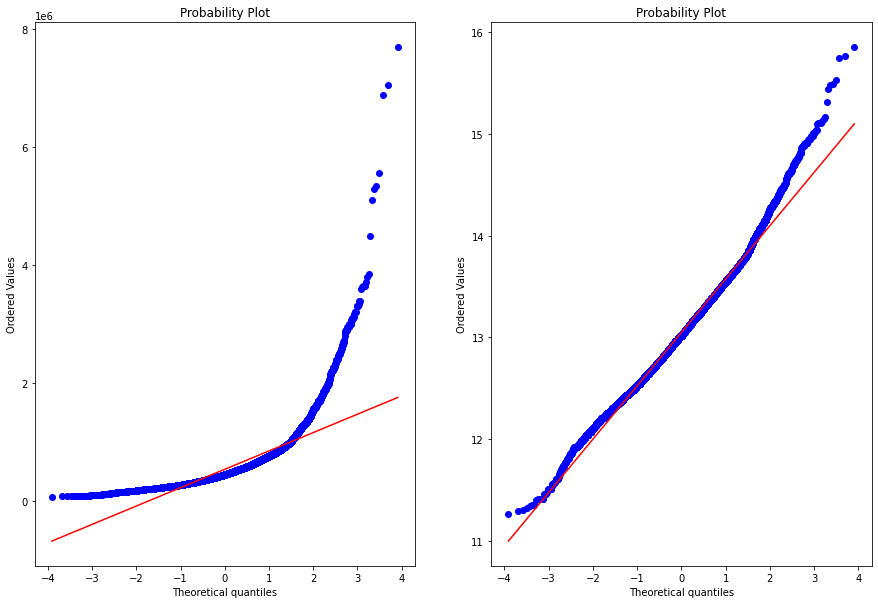

In [17]:
fig = plt.figure(figsize = (15,10))

fig.add_subplot(1,2,1)
res = stats.probplot(data['price'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(data['price']), plot=plt)

로그변환 적용 후의 분포

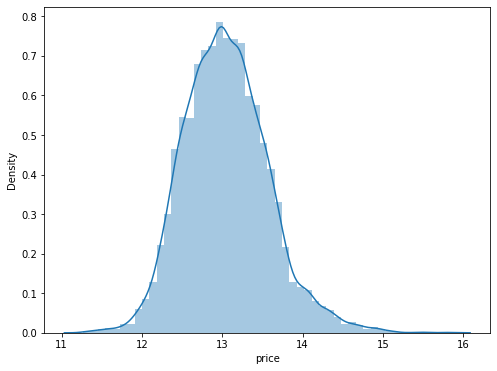

In [18]:
data['price'] = np.log1p(data['price'])

#histogram
f, ax = plt.subplots(figsize=(8, 6))
sns.distplot(data['price'])

### 2) 반응 변수 시각화
- 피어슨 상관관계 : 연속형 변수에 사용
- 스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우에 사용 

<br><br>

목적변수인 가격과 가장 상관관계가 높은 순서대로 스피어만 순위 상관관계를 본 히트맵입니다. 전부 보는 것이 아니라 분석의 편의를 위해 상관도가 높은 상위 10개의 값만 보도록 하겠습니다.

=> 목적변수와 상관도가 높은 변수는 **집의 등급 - 주거공간의 크기 - 전체 크기** 순이고 lat이라는 위도 값이 들어있습니다.

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


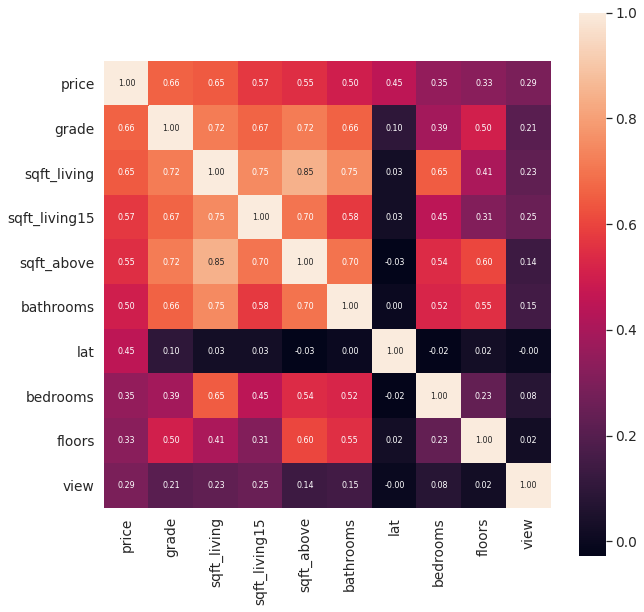

In [19]:
# correlation이 높은 상위 10개의 heatmap
# continuous + sequential variables --> spearman
# abs는 반비례관계도 고려하기 위함
import scipy as sp

cor_abs = abs(data.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(data[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

grade의 경우 *"1-3은 건물 건축 및 디자인에 미치지 못하고 7은 평균 수준의 건축 및 디자인을, 11-13은 높은 수준의 건축 및 디자인을 지니고 있습니다." * 라고 합니다.

집의 등급이 높으면 가격이 좋아지는 것은 위의 히트맵에서도 봤듯이 당연합니다. 그리고 전반적으로 상승곡선의 형태도 보이고 있습니다. 하지만

- 등급 3의 경우 값이 큰 이유
- 등급 7,8,9에서 이상치가 많은 이유
- 등급 8과 11에서 차이가 큰 이상치가 나타나는 이유

위의 3가지는 좀 더 자세히 살펴봐야 합니다.

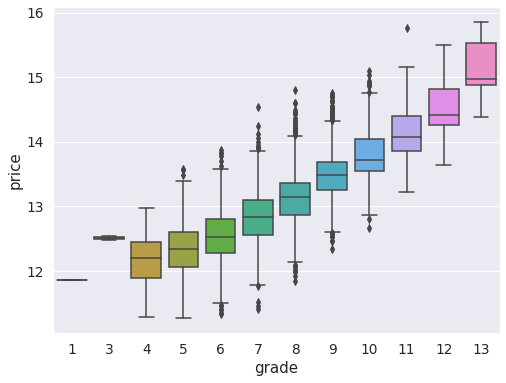

In [20]:
df = pd.concat([data['price'], data['grade']], axis=1)

f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=df)

### sqlf_living / sqlf_lot
(주거 평방 피트 / 부지 평방 피트)

1sqlf는 0.0281평입니다. sqlf_lot는 부지 평방 피트인데, 흔히 우리나라의 경우, 32평형 아파트는 일반적으로 실제로 쓰는 전용 면적은 25.7평 정도입니다. 

*즉, sqlf_living은 실제 사용 면적 / sqlf_lot는 총 부지의 면적으로 생각하면 됩니다.*

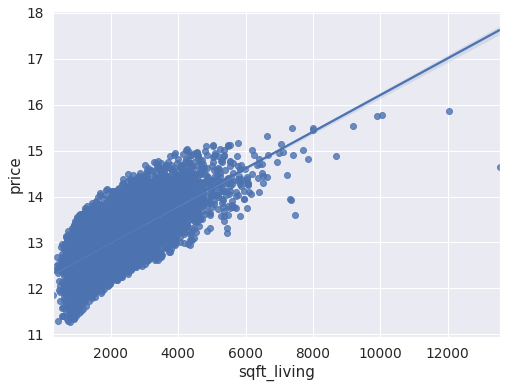

In [21]:
df = pd.concat([data['price'], data['sqft_living']], axis=1)

f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=df)

전반적으로 선형성을 보이지만 가격이 14~15사이에 sqft_living이 14000에 가까운 값은 꽤나 이상한 값(이상치)으로 생각되어집니다. <br>
제거할지 말지는 저 값을 확인해보고 결정하겠습니다. 

<br>


---

<br>

sqft_living15의 경우 15년도를 기준으로 했다보니 sqft_living에 비해 가격의 분산이 큽니다. 아무래도 재건축으로 인한 영향일 것으로 생각되어지고 sqft_living15 그 자체를 사용하기보다는 적절한 FE이 필요해 보입니다. 

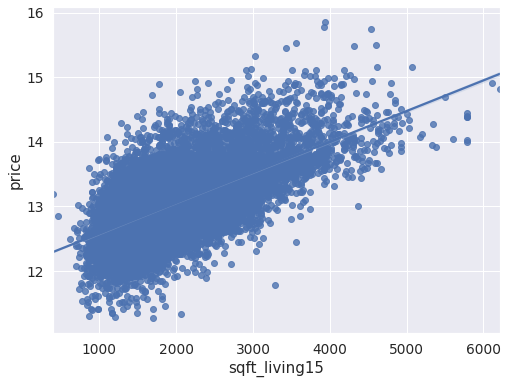

In [22]:
df = pd.concat([data['price'], data['sqft_living15']], axis=1)

f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=df)

bathrooms같은경우 소숫점이 있어서 많이 헷갈릴 수 있습니다. <br>
각각의 값이 의미하는것은 아래와 같고 위의 값만을 가지고 각각의 값이 몇개있는지는 구분하기 힘들어 보입니다. 
- 0.5 : 세면대, 화장실 
- 0.75 : 세면대, 화장실, 샤워실
- 1 : 세면대, 화장실, 샤워실, 욕조 

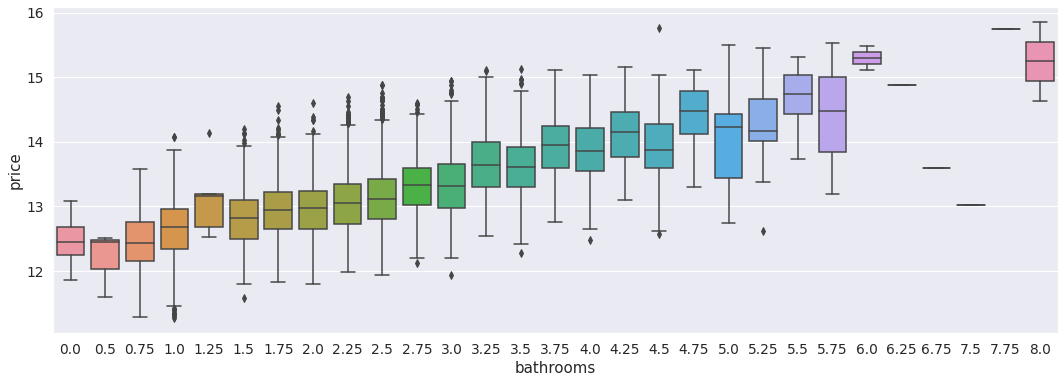

In [23]:
df = pd.concat([data['price'], data['bathrooms']], axis=1)

f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=df)

방의 경우 median 값을 중심으로 살펴보면 어느정도 선형관계를 띄는것을 볼 수 있습니다. <br>
그리고 방의 갯수가 2~6의 경우 방이 적음에도 값이 큰 값들이 많습니다. <br>
이는 우리나라의 경우처럼 방의 크기는 작아도 강남처럼 비싼 지역일 가능성이 높습니다.  

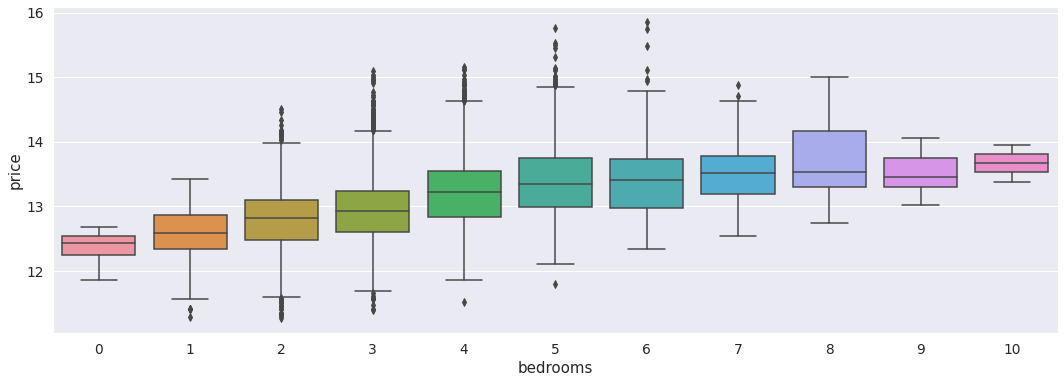

In [24]:
df = pd.concat([data['price'], data['bedrooms']], axis=1)

f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=df)

## 1.4 이상치 및 결측치 확인

### 결측치 확인
=> 결측치는 없다.

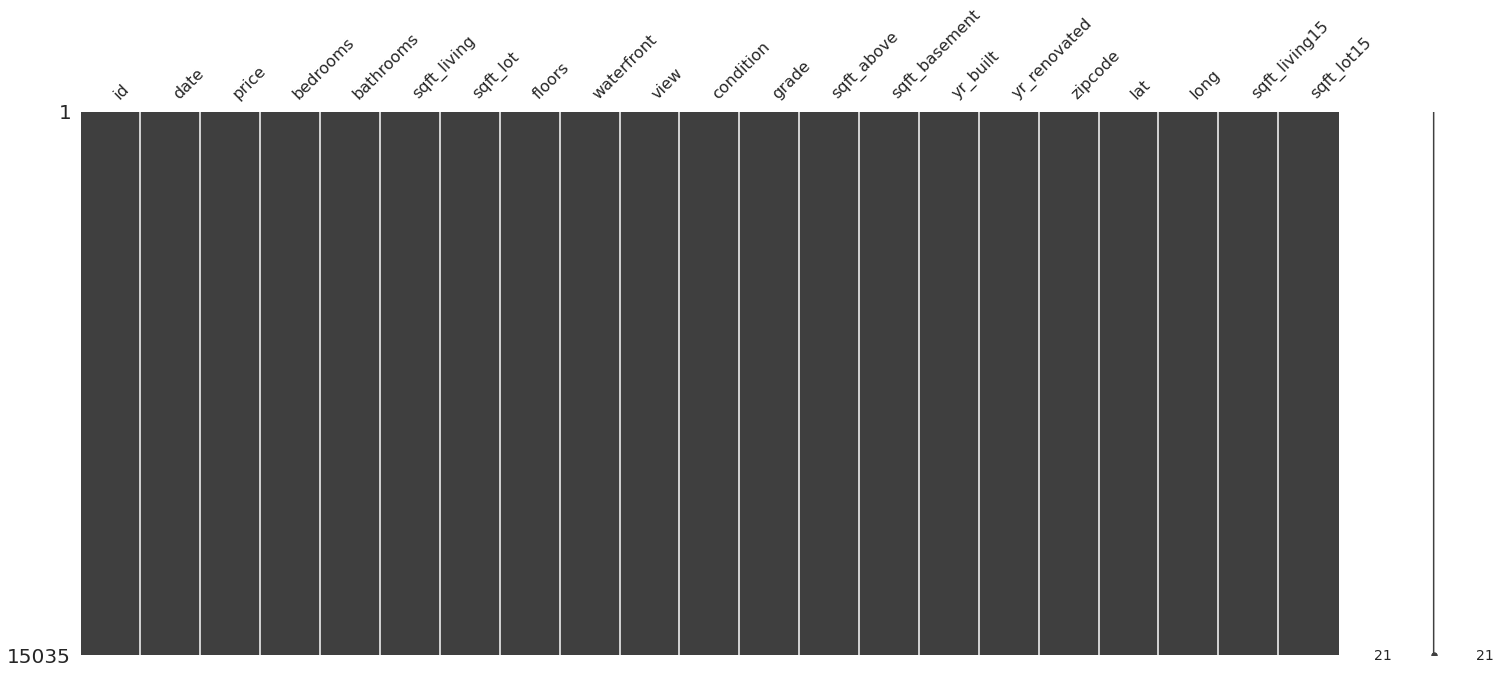

In [25]:
msno.matrix(data)

## 1.5 유니크한 데이터 수

view의 유니크갯수가 5인걸로 보니 grade같이 순위형변수로 여겨지며, <br>
waterfront의 경우는 있다/없다 2가지를 상징하는 것으로 보인다.

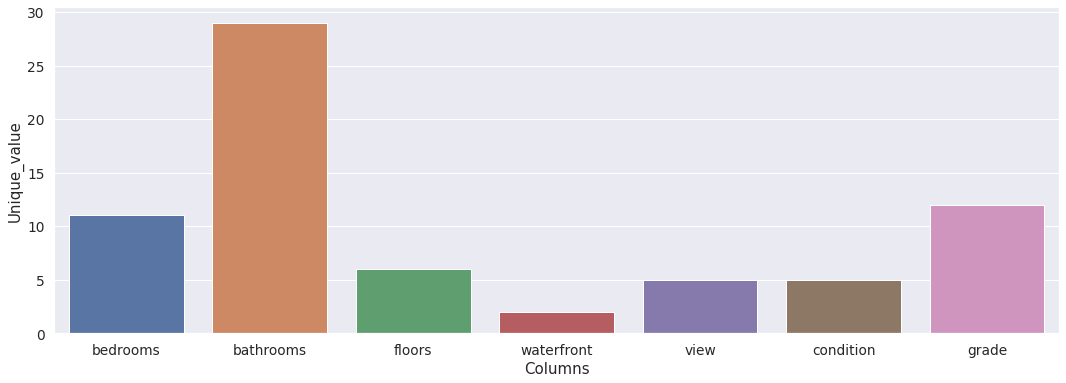

In [26]:
### 유니크 갯수 계산

train_unique = []
columns = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade']

for i in columns:
    train_unique.append(len(data[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = columns
unique_train['Unique_value'] = train_unique


f, ax = plt.subplots(figsize=(18, 6))
fig = sns.barplot(
    data= unique_train,
    x = "Columns",
    y = "Unique_value"
)

층수의 경우 1.5, 2.5, 3.5와 같이 소숫점을 가집니다. <br>
이는 미국에서 흔히 볼 수 있는 형태로 다락방을 끼고 있는 형태로 생각하면 된다.

In [27]:
data['floors'].unique()

array([1. , 2. , 1.5, 3. , 2.5, 3.5])

# 2.데이터 전처리

## 2.1 이상치 처리
위에서 중요한 변수들에 대해 시각화를 해봤을때, 다음의 변수들에 대해 이상치가 있는 것을 확인할 수 있었습니다. 
- sqft_living, grade, bedrooms 

### 1) sqft_living 처리
- 분포 다시 확인

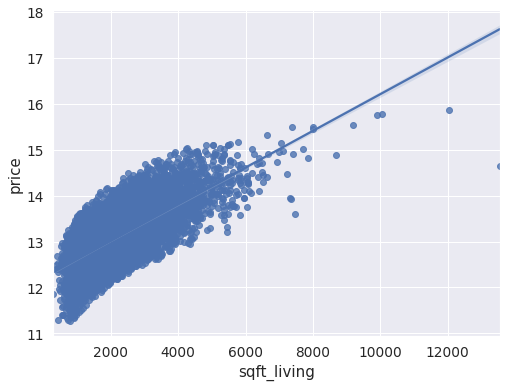

In [28]:
df = pd.concat([data['price'], data['sqft_living']], axis=1)

f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=df)

- 13000을 벗어나는 값을 확인해보자.

In [29]:
data.loc[data['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


- 이상치에 해당하는 데이터를 제외시킨다.

In [30]:
data = data.loc[data['sqft_living'] <= 13000]
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,12.309987,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,12.100718,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,13.142168,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,12.458779,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,12.583999,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,20141014T000000,13.322338,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023
15031,15031,20150326T000000,13.822984,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200
15032,15032,20140521T000000,12.793862,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
15033,15033,20150223T000000,12.899222,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200


### 2) grade 처리
- 분포 다시 확인

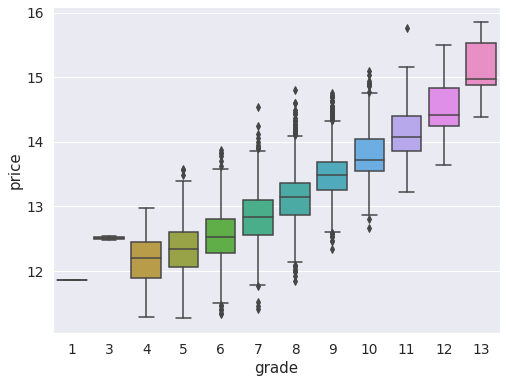

In [31]:
df = pd.concat([data['price'], data['grade']], axis=1)

f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=df)

가장 중요한 변수인 grade, sqft_ 모두 낮은 것을 볼 수 있습니다.<br>
그래서 두 값 모두 이상치로 규정하고 제거하도록 하겠습니다. 

In [32]:
data.loc[(data['price']>12) & (data['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,5,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,2,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [33]:
data.loc[(data['price']>14.5) & (data['grade'] == 7)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
12346,12346,20150115T000000,14.533351,4,3.25,3580,19989,1.5,1,4,4,7,3480,100,1915,1965,98125,47.7087,-122.276,2410,6389


In [34]:
data.loc[(data['price']>14.7) & (data['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,3,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [35]:
data.loc[(data['price']>15.5) & (data['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


특별한 이유가 없이 가격이 높아 보이므로 이상치로 규정하고 제거하도록 하겠습니다.

In [36]:
data = data.loc[data['id']!=2302]
data = data.loc[data['id']!=12346]
data = data.loc[data['id']!=4123]
data = data.loc[data['id']!=7259]
data = data.loc[data['id']!=2777]

### 3) bedrooms 처리
- 침실의 수를 보면 위에서 한 얘기와 마찬가지로 median이 양의 상관관계를 띄고 있습니다. 그리고 bedrooms가 2 ~ 6은 분산이 매우 큰 것을 확인할 수 있습니다. 가운데의 저 값들은 다른 변수들의 영향이 크므로 위의 정보만을 보고 제거하지는 않도록 하겠습니다.

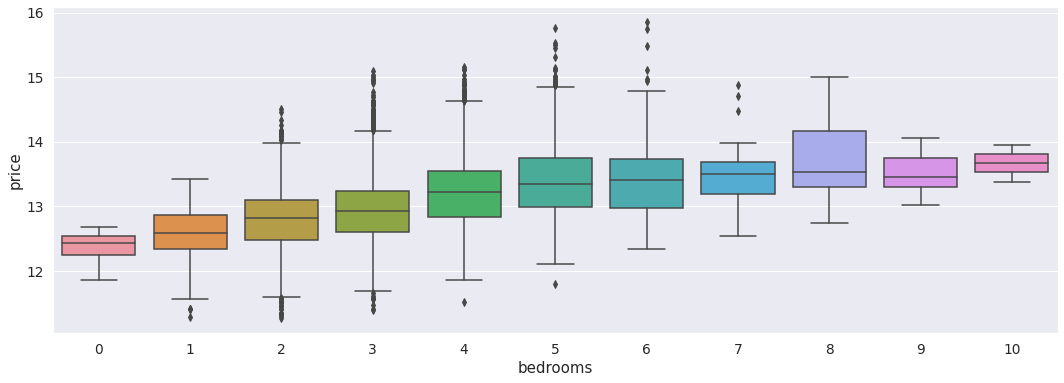

In [37]:
df = pd.concat([data['price'], data['bedrooms']], axis=1)

f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=df)

## 2.2 정규화

In [38]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']    # 로그 변환 적용할 칼럼

for c in skew_columns:
    data[c] = np.log1p(data[c].values)
    test[c] = np.log1p(test[c].values)

## 2.3 변수 수정

In [39]:
for df in [data, test]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

# 3.변수 생성

In [40]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,2238,6819
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711


In [41]:
for df in [data, test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

In [42]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650,4.00,0.818803,7.074117,1.0,0.237168,0
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062,3.00,0.721756,6.647688,1.0,0.337385,0
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503,5.00,0.825489,7.427144,1.0,0.239904,0
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,2238,6819,5.25,0.843688,7.447751,1.0,0.328201,0
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711,4.50,0.758837,6.966967,1.0,0.169910,0


In [43]:
# 평당 가격
data['per_price'] = data['price']/data['sqft_total_size']
zipcode_price = data.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
data = pd.merge(data,zipcode_price,how='left',on='zipcode')
test = pd.merge(test,zipcode_price,how='left',on='zipcode')

for df in [data, test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

del data['per_price']

In [44]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,zipcode_mean,zipcode_var
0,0,20141013,12.309987,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,1955.0,98178,47.5112,-122.257,1340,5650,4.00,0.818803,7.074117,1.0,0.237168,0,9.368147,1.214207
1,1,20150225,12.100718,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,1933.0,98028,47.7379,-122.233,2720,8062,3.00,0.721756,6.647688,1.0,0.337385,0,9.257745,1.023549
2,2,20150218,13.142168,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,1987.0,98074,47.6168,-122.045,1800,7503,5.00,0.825489,7.427144,1.0,0.239904,0,11.307711,0.826257
3,3,20140627,12.458779,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,1995.0,98003,47.3097,-122.327,2238,6819,5.25,0.843688,7.447751,1.0,0.328201,0,10.626177,1.012780
4,4,20150115,12.583999,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,1963.0,98198,47.4095,-122.315,1650,9711,4.50,0.758837,6.966967,1.0,0.169910,0,10.032009,1.002206


### train데이터와 target데이터 분리

In [45]:
y = data['price']
del data['price']

y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15024    13.322338
15025    13.822984
15026    12.793862
15027    12.899222
15028    12.691584
Name: price, Length: 15029, dtype: float64

#4.모델링

## ✓ 튜닝해볼 수 있는 모델 클래스 인자

대표적으로 자주 튜닝하는 lightgbm 라이브러리의 인자는 다음과 같다.

- max_depth : 의사 결정 나무의 깊이, 정수 사용
- learning_rate : 한 스텝에 이동하는 양을 결정하는 파라미터, 보통 0.0001\~0.1 사이의 실수 사용
- n_estimators : 사용하는 개별 모델의 개수, 보통 50~100 이상의 정수 사용
- num_leaves : 하나의 LightGBM 트리가 가질 수 있는 최대 잎의 수
- boosting_type : 부스팅 방식, gbdt, rf 등의 문자열 입력

파라미터 조합과 score, RMSLE가 담긴 DataFrame을 반환한다.

In [46]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [47]:
random_state=2021         # 시드값 고정

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [48]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

In [49]:
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

In [50]:
# 하이퍼파라미터 값 설정
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

# 모델 초기화
model = LGBMRegressor(random_state=random_state)

# 직접 작성한 '그리드 탐색' 함수
my_GridSearch(model, data, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  20 out of  20 | elapsed:    9.2s finished


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027253,0.165083
2,10,50,-0.029324,0.171243
1,1,100,-0.054841,0.234181
0,1,50,-0.073244,0.270637


In [51]:
data

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,zipcode_mean,zipcode_var
0,0,20141013,3,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,1955.0,98178,47.5112,-122.257,1340,5650,4.00,0.818803,7.074117,1.000000,0.237168,0,9.368147,1.214207
1,1,20150225,2,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,1933.0,98028,47.7379,-122.233,2720,8062,3.00,0.721756,6.647688,1.000000,0.337385,0,9.257745,1.023549
2,2,20150218,3,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,1987.0,98074,47.6168,-122.045,1800,7503,5.00,0.825489,7.427144,1.000000,0.239904,0,11.307711,0.826257
3,3,20140627,3,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,1995.0,98003,47.3097,-122.327,2238,6819,5.25,0.843688,7.447751,1.000000,0.328201,0,10.626177,1.012780
4,4,20150115,3,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,1963.0,98198,47.4095,-122.315,1650,9711,4.50,0.758837,6.966967,1.000000,0.169910,0,10.032009,1.002206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15024,15030,20141014,4,2.50,7.832411,8.703507,2.0,0,0,3,9,7.832411,0.000000,2014,2014.0,98056,47.5137,-122.167,2520,6023,6.50,0.899914,7.832411,1.000000,0.418396,0,11.842391,0.975946
15025,15031,20150326,4,3.50,8.163656,8.881975,2.0,0,0,3,9,7.863651,6.814543,2009,2009.0,98136,47.5537,-122.398,2050,6200,7.50,0.919126,14.678194,0.556176,0.330645,0,19.305049,2.547057
15026,15032,20140521,3,2.50,7.333676,7.031741,3.0,0,0,3,8,7.333676,0.000000,2009,2009.0,98103,47.6993,-122.346,1530,1509,5.50,1.042939,7.333676,1.000000,1.013917,0,11.038663,1.202774
15027,15033,20150223,4,2.50,7.745436,8.668024,2.0,0,0,3,8,7.745436,0.000000,2014,2014.0,98146,47.5107,-122.362,1830,7200,6.50,0.893564,7.745436,1.000000,0.254167,0,11.293382,1.173477


In [52]:
test

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,total_rooms,sqft_ratio,sqft_total_size,sqft_ratio_1,sqft_ratio15,is_renovated,zipcode_mean,zipcode_var
0,15035,20141209,3,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,1991.0,98125,47.7210,-122.319,1690,7639,5.25,0.883465,13.676905,0.574110,0.221233,1,19.255794,2.321564
1,15036,20141209,4,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,1965.0,98136,47.5208,-122.393,1360,5000,7.00,0.890086,13.772040,0.550478,0.272000,0,18.113257,2.389816
2,15037,20140512,4,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,2001.0,98053,47.6561,-122.005,4760,101930,8.50,0.745577,15.600098,0.551153,0.046699,0,25.917920,0.737584
3,15038,20150415,3,1.00,7.484930,8.918784,1.0,0,0,3,7,6.957497,6.594413,1960,1960.0,98146,47.5123,-122.337,1780,8113,4.00,0.839232,13.551911,0.552315,0.219401,0,19.759625,2.053191
4,15039,20150312,3,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,2003.0,98038,47.3684,-122.031,2390,7570,5.50,0.858454,7.544861,1.000000,0.315720,0,11.947244,0.477170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,20140626,3,1.75,7.313887,9.390075,1.0,0,0,3,6,7.313887,0.000000,2014,2014.0,98010,47.3095,-122.002,1320,11303,4.75,0.778895,7.313887,1.000000,0.116783,0,11.526568,0.619162
6464,21499,20150126,3,2.00,7.307202,7.027315,3.0,0,0,3,8,7.307202,0.000000,2014,2014.0,98144,47.5699,-122.288,1400,1230,5.00,1.039829,7.307202,1.000000,1.138211,0,9.258074,1.157439
6465,21500,20150219,3,2.50,7.178545,7.166266,2.0,0,0,3,8,7.074117,4.875197,2008,2008.0,98116,47.5773,-122.409,1330,1265,5.50,1.001714,11.949314,0.600750,1.051383,0,15.373075,1.947537
6466,21501,20140623,2,0.75,6.928538,7.208600,2.0,0,0,3,7,6.928538,0.000000,2009,2009.0,98144,47.5944,-122.299,1020,2007,2.75,0.961149,6.928538,1.000000,0.508221,0,8.778314,1.097460


In [53]:
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)

model.fit(data, y)

prediction = model.predict(test)

prediction

array([13.09459515, 13.06965684, 14.18402904, ..., 13.01867515,
       12.68246663, 12.97494731])

In [54]:
prediction = np.expm1(prediction)

prediction

array([ 486305.88450845,  474328.18564671, 1445590.35981185, ...,
        450752.16035355,  322050.46229685,  431466.43223842])

In [55]:
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [58]:
save_submission(model, data, y, test, 'lgbm', rmsle='1')

/content/drive/MyDrive/Colab Notebooks/AIFFEL_LMS/data/submission_lgbm_RMSLE_1.csv saved!


# 프로젝트 루브릭 (평가 기준)
- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
- 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

# 회고

평소에 주로 함수로 구현하지 않았었는데 이번 프로젝트를 통해 다양한 시도가 필요한 머신러닝 훈련을 위해서는 함수로 구현해놓는 것이 훨씬 유용하다는 것을 직접 깨달았다.

<br>

그리고 그리드탐색이라는 하이퍼파라미터 튜닝 방법을 알게 되어서 앞으로도 유용하게 사용할 것 같다.